In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skimage
from skimage.measure import block_reduce
from IPython.display import clear_output
import os

# Optional
## Check a data file and ensure columns match the requirement ['X', 'Y', 'U','V', 'P', 'T']
### Drop any additional columns

In [ ]:
path = "/scratch/jtb3sud/TNT/183102/TNT_1.730000MICRON_1.000000Gpa/xyuvpTLs_ts0006000.dat"
#path = "/home/pdy2bw/Research/PARCv2/Void_Collapse.interp.ts0003000.dat"

os.path.exists(path)

read_data = np.genfromtxt(path, 
                        invalid_raise=False, 
                        missing_values=None)
clear_output(wait=True)

df = pd.DataFrame(read_data, columns =['X', 'Y', 'U','V', 'P', 'T', 'Ls']) 
df = df.drop(['Ls'], axis=1)
df.head(5)
print(df)

# Required
## Once file is in correct format, run data conversion: raw -> numpy 

In [ ]:
import numpy as np
import pandas as pd
import os

def process_file(filepath):
    """
    Process a single file.
    """
    # Read data from file
    read_data = np.genfromtxt(filepath, invalid_raise=False, missing_values=None)
    #print(read_data)
    
    df = pd.DataFrame(read_data, columns=['X', 'Y', 'U', 'V', 'P', 'T', 'Ls'])
    df = df.drop(['Ls'], axis=1)
    #print("----------------------------------------------",df)
    # Process temperature field
    temperature_snapshot_raw = df.pivot_table(index='X', columns='Y', values='T').T.values
    #print("raw", temperature_snapshot_raw)
    temperature_snapshot = pd.DataFrame(temperature_snapshot_raw).round(6).to_numpy()
    temperature_snapshot = np.expand_dims(temperature_snapshot, axis=2)
    #print("temperature", temperature_snapshot)

    # Process pressure field
    pressure_snapshot_raw = df.pivot_table(index='X', columns='Y', values='P').T.values
    pressure_snapshot = pd.DataFrame(pressure_snapshot_raw).round(6).to_numpy()
    pressure_snapshot = np.expand_dims(pressure_snapshot, axis=2)

    # Process microstructure field
    microstructure_snapshot = temperature_snapshot

    # Process velocity_x field
    vx_snapshot_raw = df.pivot_table(index='X', columns='Y', values='U').T.values
    vx_snapshot = pd.DataFrame(vx_snapshot_raw).round(6).to_numpy()
    vx_snapshot = np.expand_dims(vx_snapshot, axis=2)

    # Process velocity_y field
    vy_snapshot_raw = df.pivot_table(index='X', columns='Y', values='V').T.values
    vy_snapshot = pd.DataFrame(vy_snapshot_raw).round(6).to_numpy()
    vy_snapshot = np.expand_dims(vy_snapshot, axis=2)

    # Combine all snapshots
    coupled_field_snapshot = np.concatenate([temperature_snapshot,
                                              pressure_snapshot,
                                              microstructure_snapshot,
                                              vx_snapshot,
                                              vy_snapshot], axis=2)
    # Cut off temperature to have value from 300 - max temp
    # how do we choose these numbers
    coupled_field_snapshot[:,:,0][coupled_field_snapshot[:,:,0] < 300] = 300
    coupled_field_snapshot[:,:,0][coupled_field_snapshot[:,:,0] > 5000] = 7000
    
    # Convert microstructure field to binary image
    coupled_field_snapshot[:,:,2][coupled_field_snapshot[:,:,2] > 280] = 280
    coupled_field_snapshot[:,:,2][coupled_field_snapshot[:,:,2] < 280] = 0
#    
    return coupled_field_snapshot




def process_subdirectory(subdirectory, np_directory):
    """
    Process all files in a subdirectory.
    """
    

    # Loop through each subdirectory in the subdirectory
    for inner_subdirectory in os.listdir(subdirectory):
        inner_subdirectory_path = os.path.join(subdirectory, inner_subdirectory)
        #print("inner_subdirectory", inner_subdirectory_path)
        
        # Check if the path is a directory
        if os.path.isdir(inner_subdirectory_path):
            # List all files in the inner subdirectory
            files = os.listdir(inner_subdirectory_path)

            # Extract ts from each file name and sort files based on ts
            files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0][2:]))
            # hold the data
            coupled_field_evolution = []
            # Loop through each file in the inner subdirectory
            for filename in files:
                filepath = os.path.join(inner_subdirectory_path, filename)
                #print("filepath", filepath)

                # Check if the path is a file
                if os.path.isfile(filepath):
                    # Process the file and append the snapshot to the list
                    snapshot = process_file(filepath)
                    #print(snapshot)
                    coupled_field_evolution.append(snapshot)
            coupled_field_evolution = np.concatenate(coupled_field_evolution, axis = 2)
            last_part = subdirectory[subdirectory.rfind('/') + 1:]
            np.save(os.path.join(np_directory, f'{last_part}.npy'), coupled_field_evolution)

    return




def process_directory(root_directory, np_directory):
    """
    Process all subdirectories in the root directory.
    """
    #data_snapshots = []

    # Loop through each subdirectory in the root directory
    i = 0
    for subdirectory in os.listdir(root_directory):
        i += 1
        subdirectory_path = os.path.join(root_directory, subdirectory)
        #print("subdirectory", subdirectory_path)
        
        # Check if the path is a directory
        if os.path.isdir(subdirectory_path):
            # Process the subdirectory and append the snapshots to the list
            process_subdirectory(subdirectory_path, np_directory)
            #data_snapshots.extend(snapshots)
            
        print("File number", i, "complete")
            

    return 


def main():
    """
    Main function to start the process.
    """
    # Define the root directory to start processing
    root_directory = '/scratch/jtb3sud/TNT/'
    np_directory = '/scratch/jtb3sud/tnt_np/'

    # Process the root directory
    process_directory(root_directory, np_directory)
    
    return 

#if __name__ == "__main__":
#    main()

hold = main()


In [ ]:
import sys
sys.path.append("/sfs/qumulo/qhome/jtb3sud/PARCv2")
from PARC.utils import convert_data_to_numpy
"""
Convert raw data to numpy arrays.
"""
# Define the root directory to start processing
root_directory = '/scratch/jtb3sud/TNT/'
np_directory = '/scratch/jtb3sud/tnt_np/'

convert_data_to_numpy(root_directory, np_directory) 

# Split into Training and Testing

In [ ]:
import sys
sys.path.append("/sfs/qumulo/qhome/jtb3sud/PARCv2")
from PARC.utils import split_data_into_train_test

# Set the paths
folder_path = '/scratch/jtb3sud/tnt_np'
training_path = '/scratch/jtb3sud/meta_data/tnt/training'
testing_path = '/scratch/jtb3sud/meta_data/tnt/testing'

# Call the function to split data into training and testing directories
split_data_into_train_test(folder_path, training_path, testing_path)


# Visualize the data to ensure it was converted properly

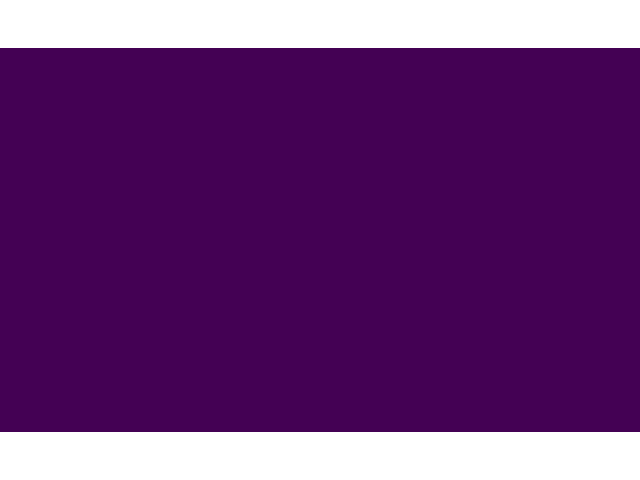

In [1]:
import os
os.chdir("/sfs/qumulo/qhome/jtb3sud/PARCv2")
from PARC.utils import create_gif_from_numpy_array

create_gif_from_numpy_array('/scratch/jtb3sud/meta_data/tnt/training/183119.npy', '/sfs/qumulo/qhome/jtb3sud/PARCv2/PARC/data/gifs/5733390_animation.gif')


# Save the data as groundtruth for PARCv2 predictions and comparison

In [2]:
import os
os.chdir("/sfs/qumulo/qhome/jtb3sud/PARCv2")
from PARC.data.data_meta_learning import data_gt
seq_clipped = data_gt(sequence_length = 52, n_state_var = 3, folder_path="/scratch/jtb3sud/meta_data/tnt/testing", result_path = "/scratch/jtb3sud/results/gt")
print(seq_clipped.shape)

Processing 183139.npy
Shape of seq_case before appending: (1, 150, 250, 260)
Length of data_whole after appending: 1
Processing 183131.npy
Shape of seq_case before appending: (1, 150, 250, 260)
Length of data_whole after appending: 2
Processing 183117.npy
Shape of seq_case before appending: (1, 150, 250, 260)
Length of data_whole after appending: 3
Processing 183138.npy
Shape of seq_case before appending: (1, 150, 250, 260)
Length of data_whole after appending: 4
Processing 183116.npy
Shape of seq_case before appending: (1, 150, 250, 260)
Length of data_whole after appending: 5
Processing 183143.npy
Shape of seq_case before appending: (1, 150, 250, 260)
Length of data_whole after appending: 6
Ground truth saved!
(6, 150, 250, 260)
